<a href="https://colab.research.google.com/github/lonj22803/Clasificacion_de_textos_sentiment_analysis_y_word-_embeddings/blob/main/Taller_2_Clasificacion_de_textos%2C_sentiment_analysis_y_word_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Taller 2: Clasificacion de textos, sentiment analysis y word embeddings.**  
Tecnicas de Procesamiento de Lenguaje Natural\
Maestria en Ingenieria Electrica - Maestria en Ingenieria de Sistemas

---
Universidad Tecnologica de Pereira  
Profesor: Julian David Echeverry Correa  
**Entregado por:**   
Juan Jose Londoño Cardenas y Juan Camilo Chavarro Acosta

### Librerias para el desarollo del taller

Aqui estaran todas la librerias utilizadas para el desarrollo del taller.

In [1]:
#Paquetes necesarios para el desarrollo del taller
!pip install -q transformers
!pip install pyspellchecker==0.7.2
!spacy download es_core_news_sm
!pip install colorlog
!pip install pdfminer.six
!pip install pyLDAvis
!pip install pandas
!pip install matplotlib
!pip install nltk
!pip install numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2023-06-22 03:45:44.720244: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-22 03:45:49.826129: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 52.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/

In [148]:
#Librerias para el desarrollo del taller
import re
import os
import requests
import random
import itertools
import shutil
import nltk
import spacy
import pprint
import itertools
import logging
import warnings
import pickle
import gensim
import pyLDAvis
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyLDAvis.gensim_models as gensimvis

from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


from scipy.sparse import csr_matrix
from spellchecker import SpellChecker
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

from pdfminer.high_level import extract_text

from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer

from transformers import pipeline

from colorlog import ColoredFormatter
from datetime import datetime
from enum import Enum

from gensim import corpora
from gensim.models import LdaModel, LsiModel, RpModel
from gensim.models.coherencemodel import CoherenceModel

from mpl_toolkits.mplot3d import Axes3D

warnings.filterwarnings('ignore')

In [3]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [4]:
#Usando las herramienta utilizadas en el primer taller para el preprocesamienot de textos se especifican las siguientes funciones.

# Tokenización
def tokenize_text(text):
    return word_tokenize(text)

# Lematización
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text)])

def lemmatize_text_lang(text, language):
    nlp = spacy.load(f"{language}_core_news_sm")
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

# Modificación de la lista de stopwords
def modify_stopwords(text, new_stopwords=[], remove_stopwords=[]):
    stop_words = set(stopwords.words('spanish'))

    # Agrega nuevas stopwords
    for word in new_stopwords:
        stop_words.add(word)

    # Elimina stopwords
    for word in remove_stopwords:
        stop_words.discard(word)

    return ' '.join([word for word in word_tokenize(text) if word not in stop_words])

## Cargar texto
Con el fin de facilitar la revisión, se cargarán los textos directamente desde Github, esto evitará problemas con los archivos, accesos a drive u otra complicación que no permita la compilacion del codigo por parte del uso de los textos.

In [5]:
# URL del archivo de texto en GitHub
url = 'https://raw.githubusercontent.com/lonj22803/Clasificacion_de_textos_sentiment_analysis_y_word-_embeddings/main/corpus_4T.tab'
# Realizar la solicitud HTTP
response = requests.get(url)

# Verificar el estado de la respuesta
if response.status_code == 200:
    # Guardar el contenido en un archivo local
    with open('corpus_4T.tab', 'w') as file:
        file.write(response.text)
        print("Archivo llamado corpus_4T.tab guardado exitosamente.")
else:
    print("No se pudo acceder al archivo en GitHub.")


Archivo llamado corpus_4T.tab guardado exitosamente.


In [6]:
# URL del archivo de texto en GitHub
url2 = 'https://raw.githubusercontent.com/JorgeDuenasLerin/diccionario-espanol-txt/master/0_palabras_todas.txt'
# Verificar el estado de la respuesta
if response.status_code == 200:
    # Guardar el contenido en un archivo local
    with open('diccionario.txt', 'w') as file:
        file.write(response.text)
        print("Archivo llamado diccionario.txt guardado exitosamente.")
else:
    print("No se pudo acceder al archivo en GitHub.")

Archivo llamado diccionario.txt guardado exitosamente.


In [7]:
# URL del archivo de texto en GitHub
url3 = 'https://raw.githubusercontent.com/DMGochoa/NLP-Msc-Class/main/Taller2/Data/Sentiment_Data/twitter_training.csv'

# Realizar la solicitud HTTP para obtener el contenido del archivo CSV
response = requests.get(url3)

# Verificar el estado de la respuesta
if response.status_code == 200:
    # Guardar el contenido en un archivo local
    with open('twitter_training.csv', 'w') as file:
        file.write(response.text)
    print("Archivo llamado twitter_training.csv guardado exitosamente.")
else:
    print("No se pudo acceder al archivo en GitHub.")

Archivo llamado twitter_training.csv guardado exitosamente.


In [8]:
# Ruta de origen de los archivos PDF
ruta_origen = "/content"  # Cambia esto según la ubicación real de tus archivos PDF

# Ruta de destino de la carpeta
ruta_destino = "/content/Docs_para_classif"  # Cambia esto si deseas utilizar una ubicación diferente para la carpeta de destino

# Nombres de los archivos PDF
nombres_archivos = ["EEG01.pdf", "EEG02.pdf", "EEG03.pdf", "EEG04.pdf",
                    "MOT01.pdf", "MOT02.pdf", "MOT03.pdf",
                    "NLP01.pdf", "NLP02.pdf", "NLP03.pdf", "NLP04.pdf"]

# Crear la carpeta de destino si no existe
shutil.rmtree(ruta_destino, ignore_errors=True)
shutil.os.makedirs(ruta_destino)

# Mover los archivos PDF a la carpeta de destino
for nombre_archivo in nombres_archivos:
    ruta_origen_archivo = shutil.os.path.join(ruta_origen, nombre_archivo)
    ruta_destino_archivo = shutil.os.path.join(ruta_destino, nombre_archivo)
    shutil.move(ruta_origen_archivo, ruta_destino_archivo)

print("Archivos movidos correctamente.")

Archivos movidos correctamente.


In [86]:
# URL del archivo de texto en GitHub
url4 = 'https://raw.githubusercontent.com/chaithanya21/Sentiment-Analysis-using-Pyspark-on-Multi-Social-Media-Data/master/redt_dataset.csv'

# Realizar la solicitud HTTP para obtener el contenido del archivo CSV
response = requests.get(url4)

# Verificar el estado de la respuesta
if response.status_code == 200:
    # Guardar el contenido en un archivo local
    with open('Reddit_Data.csv', 'w') as file:
        file.write(response.text)
    print("Archivo llamado Reddit_Data.csv guardado exitosamente.")
else:
    print("No se pudo acceder al archivo en GitHub.")

Archivo llamado Reddit_Data.csv guardado exitosamente.


In [156]:
# URL del archivo de texto en GitHub
url5 = 'https://raw.githubusercontent.com/rajasinghr/Sentiment-Analyzer-Big-Data-Project/master/Dataset/testReviews.txt'

# Realizar la solicitud HTTP para obtener el contenido del archivo CSV
response = requests.get(url5)

# Verificar el estado de la respuesta
if response.status_code == 200:
    # Guardar el contenido en un archivo local
    with open('test.ft.txt', 'w') as file:
        file.write(response.text)
    print("Archivo llamado test.ft.txt guardado exitosamente.")
else:
    print("No se pudo acceder al archivo en GitHub.")

Archivo llamado test.ft.txt guardado exitosamente.


# Parte 1 - Clasificacion de documentos

Para el siguiente punto trabajen con el corpus que se ha creado para este taller. El corpus esta contenido en el archivo <corpus 4T.tab>. Es un corpus de articulos de prensa que cubre 4 tematicas (deportes, economia, musica y politica). El formato de ese archivo es compatible con el formato de los corpus de Orange, pero si ustedes quieren trabajar directamente en python, este archivo se puede abrir como un archivo .csv sin mayores problemas (sientanse libre de modificar el formato del archivo si lo consideran necesario).

Implementen un sistema de clasificacion supervisada de textos y evaluen su rendimiento en terminos del accuracy, la precision, el recall y la f-measure. Pueden optar por clasificadores basados en distancia, clasificadoresbayesianos, maquinas de soporte vectorial o cualquier otro que ustedes consideren que puede servir para resolver esta tarea. El objetivo de este punto es que ustedes experimenten con:

* Distintas formas de preprocesado (p.ej.: tokenizacion, lematizacion, modificacion de la lista de stopwords).
* Distintas tecnicas de ponderado de terminos (p.ej.: tf-idf, binario-idf, normalizacion por longitud de documentos, normalizacion por distancia euclidiana).
* Distintas tecnicas de seleccion de terminos.
* Distintos clasificadores.

En este punto ustedes deben comparar los resultados de todas las implementaciones que realicen y concluir al
respecto. Es mas importante el analisis de los resultados que la implementacion en si misma. Al momento de presentar el analisis de resultados de este taller haganse, por ejemplo, algunas de las siguientes preguntas:  

* ¿Que tan importante es una buena estrategia de preprocesado para aumentar el rendimiento de los clasificadores?
* ¿Cual estrategia funcion o mejor (lematizacion, stemming, eliminacion de stop-words)?
* ¿Los n-gramas aportan a mejorar las tasas de acierto?
* ¿El hecho de que haya documentos mas extensos que otros afecta el entrenamiento y evaluacion de los clasificadores?
* ¿El desbalanceo de las clases (tematicas) afecta el sistema de clasificacion de documentos?
* ¿Cual es el esquema de ponderado de terminos que mejores resultados entrega? ¿A que creen que se deba esto?
* Analicen cuales documentos no fueron bien clasificados. ¿Hay clases mas dificiles de clasificar que otras? \
¿A que creen que se debe esto? ¿Es posible que haya ambiguedad en los documentos de algunas clases?


##Clases para Logger y Metricas de analisis

In [9]:
#Control de le ejecucion.
class LogLevel(Enum):
    DEBUG = logging.DEBUG
    INFO = logging.INFO
    WARNING = logging.WARNING
    ERROR = logging.ERROR
    CRITICAL = logging.CRITICAL

class CustomLogger(logging.Logger):

    def __init__(self, name, dir=None):
        """Initialize the CustomLogger class.

        Args:
            name (str): The name of the logger.
        """
        super().__init__(name)  # Call the parent class's init function
        self.handlers = []  # Initialize an empty handlers list
        # Define the directory name
        if isinstance(dir, str):
            self.log_dir = os.path.join(dir, 'Log')
        else:
            self.log_dir = 'Log'

        # Set up a temporary logger for handling possible errors during logger configuration
        self.temp_logger = logging.getLogger(name + "_temp")
        self.temp_logger.addHandler(logging.StreamHandler())
        self.temp_logger.setLevel(logging.DEBUG)

        self.__configure()  # Configure the logger

    def __create_log_dir(self):
        """Create the log directory if it doesn't already exist.

        Returns:
            str: The name of the log directory.
        """
        try:
            if not os.path.exists(self.log_dir):  # If the directory does not exist,
                os.makedirs(self.log_dir)  # create it
        except Exception as e:
            # Log the error with the temporary logger
            self.temp_logger.error(f"Error while creating log directory: {e}")
        return self.log_dir

    def __configure(self):
        """Configure the logger's settings and handlers.
        """
        # Define the log format
        log_format = "%(log_color)s [%(asctime)s] [%(levelname)s] [%(name)s]  =>>>  %(reset)s %(message)s"
        formatter = ColoredFormatter(log_format, datefmt="%d-%b-%y %H:%M:%S")

        # Create a console handler and configure it
        console_handler = logging.StreamHandler()
        console_handler.setLevel(logging.DEBUG)
        console_handler.setFormatter(formatter)

        # Create the log directory
        log_dir = self.__create_log_dir()

        # Define the log file name
        log_file = os.path.join(
            log_dir, f'{datetime.now().strftime("%d-%m-%Y")}.log')

        try:
            # Create a file handler and configure it
            file_handler = logging.FileHandler(log_file)
        except Exception as e:
            # Log the error with the temporary logger
            self.temp_logger.error(f"Error while opening the log file: {e}")
            file_handler = None  # If an error occurred, set the file handler to None

        # If the file handler is successfully created, add it to the handlers list
        if file_handler is not None:
            file_handler.setLevel(logging.DEBUG)
            file_handler.setFormatter(formatter)
            self.handlers = [console_handler, file_handler]

        # Add each handler in the handlers list to the logger
        for handler in self.handlers:
            self.addHandler(handler)

        # Set the logger's level to DEBUG
        self.setLevel(logging.DEBUG)

        self.temp_logger = None  # We no longer need the temporary logger

    def set_level(self, level):
        """Set the level for this logger.

        Args:
            level (str or int): The level to set. Allowed levels are: DEBUG, INFO,
                                WARNING, ERROR, and CRITICAL.
        """
        try:
            # If level is a string, convert it to the corresponding integer value
            if isinstance(level, str):
                level = logging._nameToLevel.get(level.upper(),
                                                 LogLevel[level.upper()].value)
            # Set the logger's level
            self.setLevel(level)
        except Exception as e:
            # If an error occurs, log it
            self.error(f"Error while changing the logger's level: {e}")

    def close(self):
        """Close all handlers associated with this logger.
        """
        for handler in self.handlers:
            # Flush the handler to make sure all logging output has been emitted
            handler.flush()
            # Close the handler
            handler.close()
            # Remove the handler from this logger
            self.removeHandler(handler)
        # Clear the handlers list
        self.handlers = []

In [10]:
#Metricas del Trabajo
class ModelMetrics:
    def __init__(self):
        self.logger = CustomLogger('ModelMetrics')

    def accuracy(self, y_true, y_pred):
        """Compute the accuracy.

        Args:
            y_true: True target values
            y_pred: Estimated targets as returned by a classifier

        Returns:
            Accuracy of the classifier
        """
        self.logger.info('Calculating accuracy')
        return accuracy_score(y_true, y_pred)

    def precision(self, y_true, y_pred, average='micro'):
        """Compute the precision.

        Args:
            y_true: True target values
            y_pred: Estimated targets as returned by a classifier

        Returns:
            Precision of the classifier
        """
        self.logger.info('Calculating precision')
        return precision_score(y_true, y_pred, average=average)

    def recall(self, y_true, y_pred, average='micro'):
        """Compute the recall/sensitivity.

        Args:
            y_true: True target values
            y_pred: Estimated targets as returned by a classifier

        Returns:
            Recall of the classifier
        """
        self.logger.info('Calculating recall')
        return recall_score(y_true, y_pred,average=average)

    def specificity(self, y_true, y_pred):
        """Compute the specificity for multiclass classification.

        Computes specificity for each class and returns the average.

        Args:
            y_true: True target values
            y_pred: Estimated targets as returned by a classifier

        Returns:
            Average specificity of the classifier
        """
        self.logger.info('Calculating specificity')
        cm = confusion_matrix(y_true, y_pred)
        fp = cm.sum(axis=0) - np.diag(cm)
        fn = cm.sum(axis=1) - np.diag(cm)
        tp = np.diag(cm)
        tn = cm.sum() - (fp + fn + tp)

        # Sensitivity, hit rate, recall, or true positive rate
        tpr = tp / (tp + fn)
        # Specificity or true negative rate
        tnr = tn / (tn + fp)

        return np.mean(tnr)  # Returning the average specificity

## Desarrollo

Se lleva a cabo la carga de corpus y posteriormente se realiza las tareas de preprocesamiento, para su posterir analisis.

In [48]:
# Para este primer paso vamos a cargar el corpus 4T
# Define el nombre del archivo
filename = 'corpus_4T.tab'
# Lee el archivo CSV
df = pd.read_csv(filename, delimiter='\t', header=None, skiprows=4)
df_raw = pd.read_csv(filename, delimiter='\t', header=None, skiprows=4)
df

,0,1
0,deportes,Barcelona goleó al Ferencvaros en su debut en ...
1,deportes,Tras la victoria de Argentina sobre Uruguay en...
2,deportes,Los conceptos de la escuela holandesa que apli...
3,deportes,Morata anotó doblete y le dio la victoria a la...
4,deportes,"Con goles colombianos, River Plate clasificó a..."
...,...,...
69,politica,"De 40 a 42 horas, las diferencias que Senado y..."
70,politica,Gobierno diseñará una política pública de la n...
71,politica,Promotoras de la Especialidad Agraria dan por ...
72,politica,“Asumiré los costos de mi bolsillo”: Quintero ...


In [49]:
# Normalizacion y limpieza
df[1] = df[1].str.lower()

def remove_symbols(text, regex):
    return re.sub(regex, '', text)

df[1] = df[1].apply(lambda x: remove_symbols(x, r'[^\w\s]'))
df[1] = df[1].apply(lambda x: remove_symbols(x, r'\d+'))
print(df)

           0                                                  1
0   deportes  barcelona goleó al ferencvaros en su debut en ...
1   deportes  tras la victoria de argentina sobre uruguay en...
2   deportes  los conceptos de la escuela holandesa que apli...
3   deportes  morata anotó doblete y le dio la victoria a la...
4   deportes  con goles colombianos river plate clasificó a ...
..       ...                                                ...
69  politica  de  a  horas las diferencias que senado y cáma...
70  politica  gobierno diseñará una política pública de la n...
71  politica  promotoras de la especialidad agraria dan por ...
72  politica  asumiré los costos de mi bolsillo quintero tra...
73  politica  al defensor del pueblo se le enredó el libreto...

[74 rows x 2 columns]


In [50]:
print('El numero de elementos antes de eliminar el stopword es: ', len(df[1][0]))
df[1] = df[1].apply(lambda x: modify_stopwords(x, new_stopwords=[], remove_stopwords=[]))
print('El número de elementos antes de Lematizar: ', len(df[1][0]))
df[1] = df[1].apply(lambda x: lemmatize_text_lang(x, 'es'))
print('El número de elementos luego de realizar lematizacion y stopwords', len(df[1][0]))

El numero de elementos antes de eliminar el stopword es:  3846
El número de elementos antes de Lematizar:  2768
El número de elementos luego de realizar lematizacion y stopwords 2724


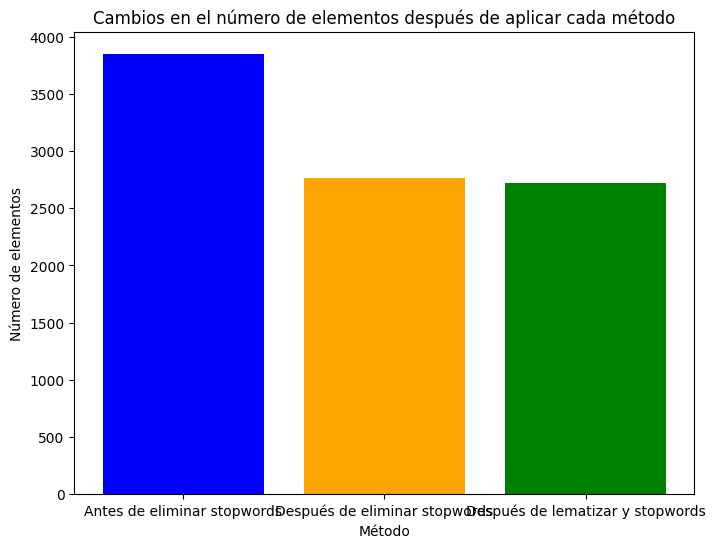

In [52]:
# Definir los datos
metodos = ['Antes de eliminar stopwords', 'Después de eliminar stopwords', 'Después de lematizar y stopwords']
num_elementos = [3846, 2768, 2724]

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(metodos, num_elementos, color=['blue', 'orange', 'green'])

# Agregar etiquetas y título
plt.xlabel('Método')
plt.ylabel('Número de elementos')
plt.title('Cambios en el número de elementos después de aplicar cada método')

# Mostrar el gráfico
plt.show()

In [15]:
# Tokenizar
df[1] = df[1].apply(tokenize_text)
df2 = df.copy()
#df[1]

In [16]:
class Combinator:
    """This class serves to execute combinations of classifiers, term weights and selectors"""

    def __init__(self, random_selection=None):
        """
        Initializes Combinator class with classifiers, term selectors and term weights.

        Args:
            random_selection (int, optional): Number of random combinations to select. Defaults to None.
        """
        self.random_selection = random_selection
        self.classifiers = {
            'SVM': SVC,
            'RANDOM_FOREST': RandomForestClassifier,
            'NAIVE_BAYES': MultinomialNB,
            'LOGISTIC_REGRESSION': LogisticRegression,
            'GRADIENT_BOOSTING': GradientBoostingClassifier
        }
        self.term_selectors = {
            'ANOVA': f_classif,
            'CHI2': chi2,
            'MUTUAL_INFO': mutual_info_classif
        }
        self.term_weights = {
            'BINARY_IDF': CountVectorizer(binary=True),
            'TFIDF': TfidfVectorizer(),
            'EUCLIDEAN_DISTANCE': self.normalize_by_euclidean_distance,
            'LENGTH': self.normalize_by_length
        }

    def get_combinations(self):
        """
        Generates all combinations of term weight, term select and classifiers.

        Returns:
            list: A list of tuples representing all possible combinations.
        """
        combinations = itertools.product(self.term_weights.keys(), self.term_selectors.keys(), self.classifiers.keys())
        return list(combinations)

    @staticmethod
    def normalize_by_length(X):
        """
        Normalizes a matrix of term counts by the length of each document.

        Args:
            X (array-like): Matrix of term counts.

        Returns:
            array-like: Matrix of term counts normalized by document length.
        """
        # Get the length (L2 norm) of each document
        lengths = np.linalg.norm(X, axis=1, ord=2)
        # Divide each row by its length
        return X / lengths[:, None]

    @staticmethod
    def normalize_by_euclidean_distance(X):
        """
        Normalizes a matrix of term counts by the Euclidean distance of each document.

        Args:
            X (array-like): Matrix of term counts.

        Returns:
            array-like: Matrix of term counts normalized by Euclidean distance.
        """
        # Calculate Euclidean distance (sqrt of sum of squares) for each document
        distances = np.sqrt(np.sum(X**2, axis=1))
        # Divide each row by its Euclidean distance
        return X / distances[:, None]

    def execute_combinations(self, X, y):
        """
        Executes combinations of term weights, term selectors and classifiers. Splits the dataset,
        applies term weight and select, trains the classifier and evaluates performance.

        Args:
            X (array-like): Training input samples.
            y (array-like): Target values.

        Returns:
            dict: A dictionary with the results of the performance evaluation.
        """
        combinations = self.get_combinations()

        # If random_selection is set, only use a subset of the combinations
        if self.random_selection is not None:
            combinations = random.sample(combinations, self.random_selection)

        self.results = {
            'term_weight': [],
            'term_selecting': [],
            'classifier': [],
            'precision': [],
            'accuracy': [],
            'sensitivity': [],
            'specificity': []
        }
        for combination in combinations:
            weight_method, select_method, classifier_method = combination

            # Split the dataset into training set and test set
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            # Apply term weight
            vectorizer = self.term_weights[weight_method]
            if weight_method in ['BINARY_IDF', 'TFIDF']:
                X_train_weighted = vectorizer.fit_transform(X_train)
                X_test_weighted = vectorizer.transform(X_test)
            else:
                count_vectorizer = CountVectorizer()
                X_train_vectorized = count_vectorizer.fit_transform(X_train)
                X_test_vectorized = count_vectorizer.transform(X_test)
                X_train_weighted = vectorizer(X_train_vectorized.toarray())
                X_test_weighted = vectorizer(X_test_vectorized.toarray())



            # Apply term select
            selector = SelectKBest(score_func=self.term_selectors[select_method], k=1000)
            X_train_selected = selector.fit_transform(X_train_weighted, y_train)
            X_test_selected = selector.transform(X_test_weighted)

            # Train the classifier and evaluate performance
            model = self.classifiers[classifier_method]()
            model.fit(X_train_selected, y_train)

            y_pred = model.predict(X_test_selected)
            # Here you should add code to evaluate the model (e.g., using cross-validation, checking accuracy on test set)
            precision = precision_score(y_test, y_pred, average='weighted')
            self.results['precision'].append(precision)
            accuracy = accuracy_score(y_test, y_pred)
            self.results['accuracy'].append(accuracy)
            sensitivity = recall_score(y_test, y_pred, average='weighted') # This is the same as sensitivity
            self.results['sensitivity'].append(sensitivity)
            specificity = ModelMetrics().specificity(y_test, y_pred)
            self.results['specificity'].append(specificity)
            self.results['term_weight'].append(weight_method)
            self.results['term_selecting'].append(select_method)
            self.results['classifier'].append(classifier_method)

        return self.results


# Uso y obtencion de resultados
texts = [' '.join(words) for words in df2[1]]
labels = df2[0]
combinator = Combinator()
results = combinator.execute_combinations(texts, labels)
results_raw = combinator.execute_combinations(df_raw[1], df_raw[0])

 [22-Jun-23 03:50:12] [INFO] [ModelMetrics]  =>>>   Calculating specificity
 [22-Jun-23 03:50:12] [INFO] [ModelMetrics]  =>>>   Calculating specificity
 [22-Jun-23 03:50:12] [INFO] [ModelMetrics]  =>>>   Calculating specificity
 [22-Jun-23 03:50:12] [INFO] [ModelMetrics]  =>>>   Calculating specificity
 [22-Jun-23 03:50:13] [INFO] [ModelMetrics]  =>>>   Calculating specificity
 [22-Jun-23 03:50:13] [INFO] [ModelMetrics]  =>>>   Calculating specificity
 [22-Jun-23 03:50:14] [INFO] [ModelMetrics]  =>>>   Calculating specificity
 [22-Jun-23 03:50:14] [INFO] [ModelMetrics]  =>>>   Calculating specificity
 [22-Jun-23 03:50:14] [INFO] [ModelMetrics]  =>>>   Calculating specificity
 [22-Jun-23 03:50:15] [INFO] [ModelMetrics]  =>>>   Calculating specificity
 [22-Jun-23 03:50:24] [INFO] [ModelMetrics]  =>>>   Calculating specificity
 [22-Jun-23 03:50:31] [INFO] [ModelMetrics]  =>>>   Calculating specificity
 [22-Jun-23 03:50:37] [INFO] [ModelMetrics]  =>>>   Calculating specificity
 [22-Jun-23 

In [17]:
result_table = pd.DataFrame(results)
result_table = result_table.sort_values(by=['precision', 'accuracy', 'sensitivity'])
#result_table.to_csv('resultados.csv')
result_table

,term_weight,term_selecting,classifier,precision,accuracy,sensitivity,specificity
57,LENGTH,MUTUAL_INFO,NAIVE_BAYES,0.619048,0.600000,0.600000,0.878205
42,EUCLIDEAN_DISTANCE,MUTUAL_INFO,NAIVE_BAYES,0.655556,0.733333,0.733333,0.918269
17,TFIDF,ANOVA,NAIVE_BAYES,0.675556,0.800000,0.800000,0.939103
27,TFIDF,MUTUAL_INFO,NAIVE_BAYES,0.675556,0.800000,0.800000,0.939103
32,EUCLIDEAN_DISTANCE,ANOVA,NAIVE_BAYES,0.675556,0.800000,0.800000,0.939103
37,EUCLIDEAN_DISTANCE,CHI2,NAIVE_BAYES,0.675556,0.800000,0.800000,0.939103
47,LENGTH,ANOVA,NAIVE_BAYES,0.675556,0.800000,0.800000,0.939103
52,LENGTH,CHI2,NAIVE_BAYES,0.675556,0.800000,0.800000,0.939103
14,BINARY_IDF,MUTUAL_INFO,GRADIENT_BOOSTING,0.855556,0.800000,0.800000,0.939103
59,LENGTH,MUTUAL_INFO,GRADIENT_BOOSTING,0.866667,0.800000,0.800000,0.940705


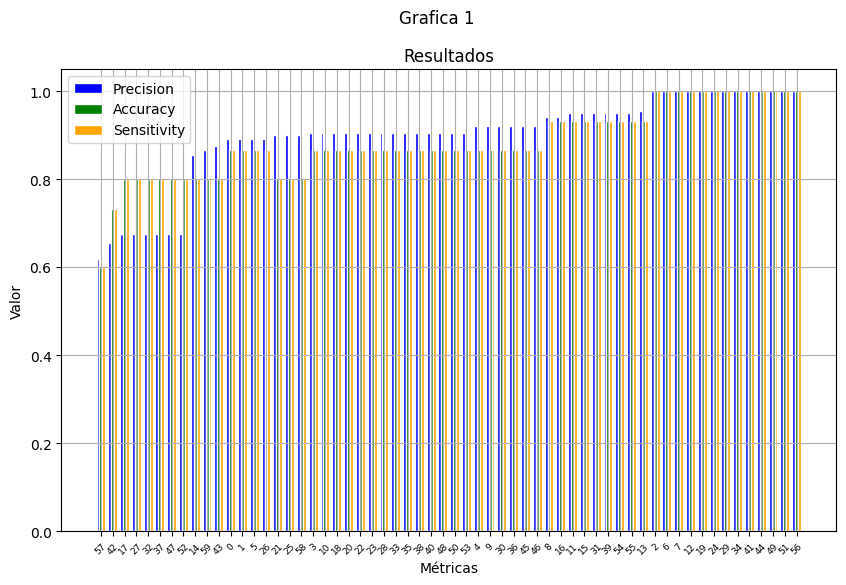

In [55]:
# Configurar los datos para el gráfico
labels = result_table.index
metrics = ['precision', 'accuracy', 'sensitivity']
values = result_table[metrics].values.T

# Configurar el tamaño de la figura
plt.figure(figsize=(10, 6))

# Configurar las posiciones de las barras
bar_width = 0.25
r1 = np.arange(len(labels))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Graficar las barras
plt.bar(r1, values[0], color='blue', width=bar_width, edgecolor='white', label='Precision')
plt.bar(r2, values[1], color='green', width=bar_width, edgecolor='white', label='Accuracy')
plt.bar(r3, values[2], color='orange', width=bar_width, edgecolor='white', label='Sensitivity')

# Configurar los títulos y etiquetas
plt.xlabel('Métricas')
plt.ylabel('Valor')
plt.title('Resultados')
plt.suptitle('Grafica 1')
plt.xticks([r + bar_width for r in range(len(labels))], labels, rotation=45, fontsize=6.5)
plt.grid()
plt.legend()

# Mostrar el gráfico
plt.show()

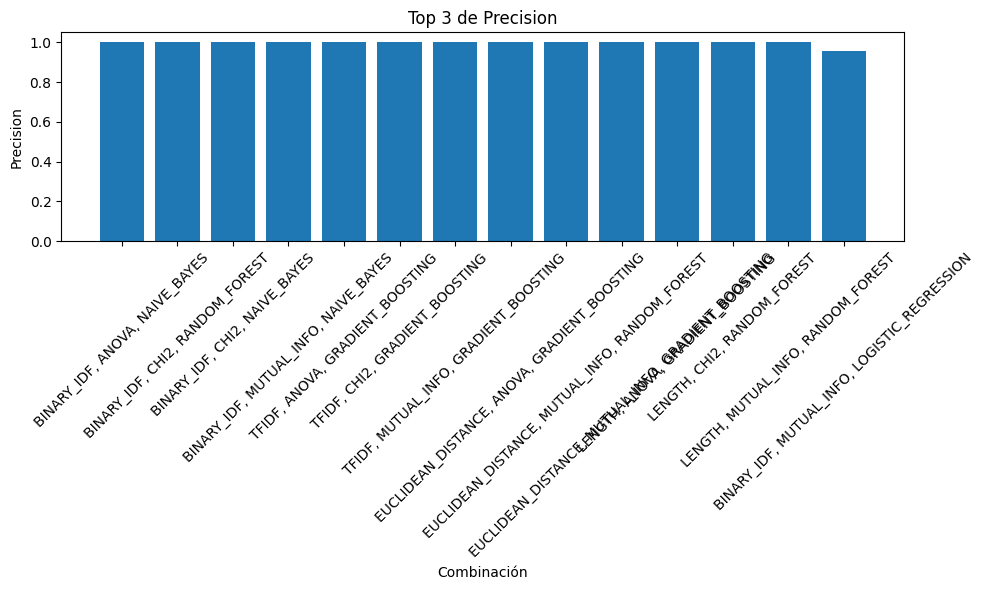

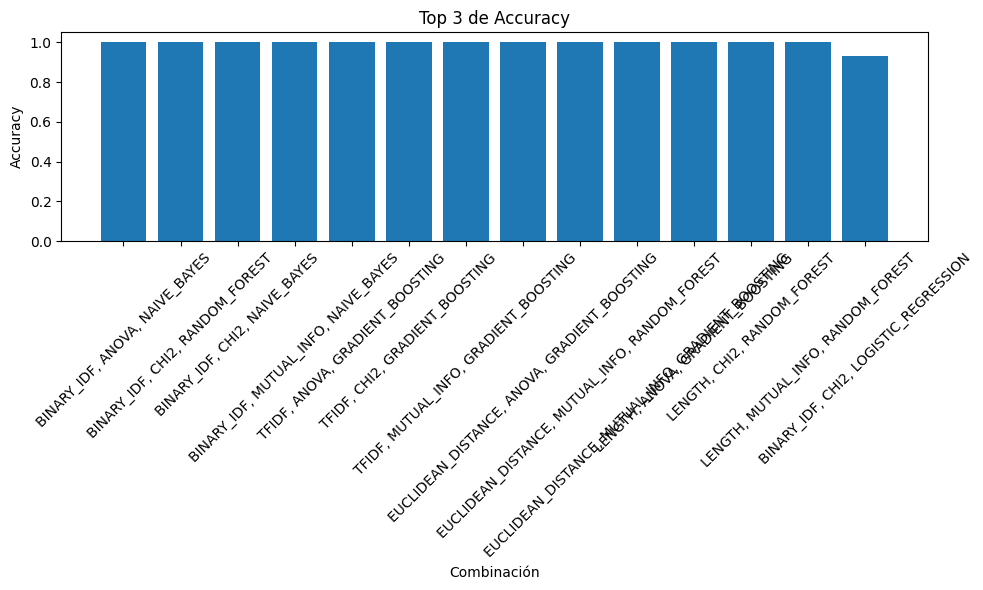

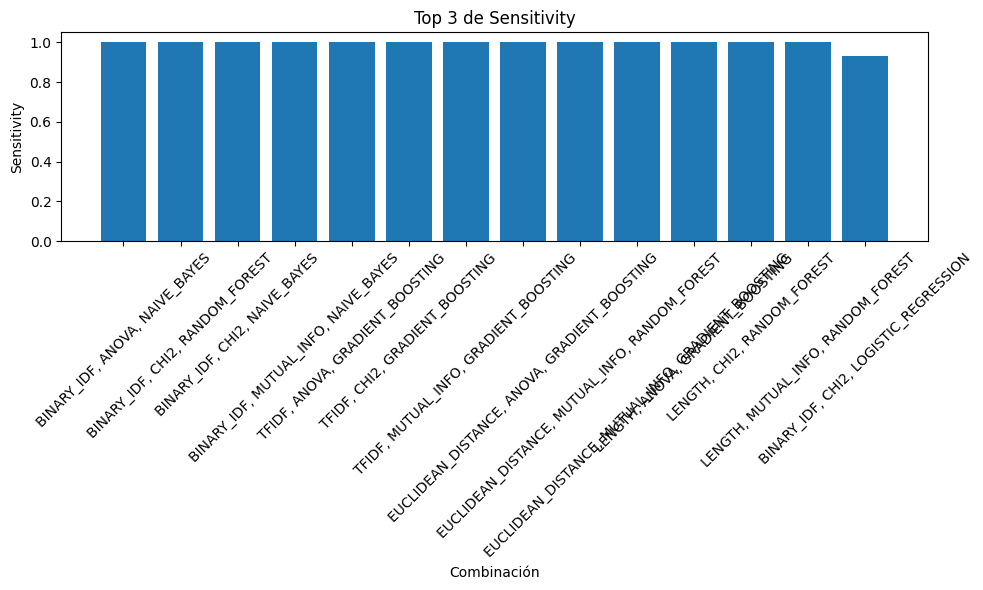

In [67]:
top_precision = result_table.nlargest(14, 'precision')
top_accuracy = result_table.nlargest(14, 'accuracy')
top_sensitivity = result_table.nlargest(14, 'sensitivity')

# Gráfica de precision
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(top_precision)), top_precision['precision'], align='center')
plt.xticks(np.arange(len(top_precision)), top_precision['term_weight'] + ', ' + top_precision['term_selecting'] + ', ' + top_precision['classifier'], rotation=45)
plt.xlabel('Combinación')
plt.ylabel('Precision')
plt.title('Top 3 de Precision')
plt.tight_layout()
plt.show()

# Gráfica de accuracy
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(top_accuracy)), top_accuracy['accuracy'], align='center')
plt.xticks(np.arange(len(top_accuracy)), top_accuracy['term_weight'] + ', ' + top_accuracy['term_selecting'] + ', ' + top_accuracy['classifier'], rotation=45)
plt.xlabel('Combinación')
plt.ylabel('Accuracy')
plt.title('Top 3 de Accuracy')
plt.tight_layout()
plt.show()

# Gráfica de sensitivity
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(top_sensitivity)), top_sensitivity['sensitivity'], align='center')
plt.xticks(np.arange(len(top_sensitivity)), top_sensitivity['term_weight'] + ', ' + top_sensitivity['term_selecting'] + ', ' + top_sensitivity['classifier'], rotation=45)
plt.xlabel('Combinación')
plt.ylabel('Sensitivity')
plt.title('Top 3 de Sensitivity')
plt.tight_layout()
plt.show()

In [57]:
result_table_raw = pd.DataFrame(results_raw)
result_table_raw = result_table_raw.sort_values(by=['precision', 'accuracy', 'sensitivity'])
#result_table.to_csv('resultados.csv')
result_table_raw

,term_weight,term_selecting,classifier,precision,accuracy,sensitivity,specificity
32,EUCLIDEAN_DISTANCE,ANOVA,NAIVE_BAYES,0.017778,0.133333,0.133333,0.750000
37,EUCLIDEAN_DISTANCE,CHI2,NAIVE_BAYES,0.017778,0.133333,0.133333,0.750000
42,EUCLIDEAN_DISTANCE,MUTUAL_INFO,NAIVE_BAYES,0.017778,0.133333,0.133333,0.750000
47,LENGTH,ANOVA,NAIVE_BAYES,0.017778,0.133333,0.133333,0.750000
52,LENGTH,CHI2,NAIVE_BAYES,0.017778,0.133333,0.133333,0.750000
57,LENGTH,MUTUAL_INFO,NAIVE_BAYES,0.017778,0.133333,0.133333,0.750000
17,TFIDF,ANOVA,NAIVE_BAYES,0.586111,0.400000,0.400000,0.818910
43,EUCLIDEAN_DISTANCE,MUTUAL_INFO,LOGISTIC_REGRESSION,0.590476,0.400000,0.400000,0.820513
27,TFIDF,MUTUAL_INFO,NAIVE_BAYES,0.593333,0.400000,0.400000,0.815705
22,TFIDF,CHI2,NAIVE_BAYES,0.596825,0.466667,0.466667,0.839744


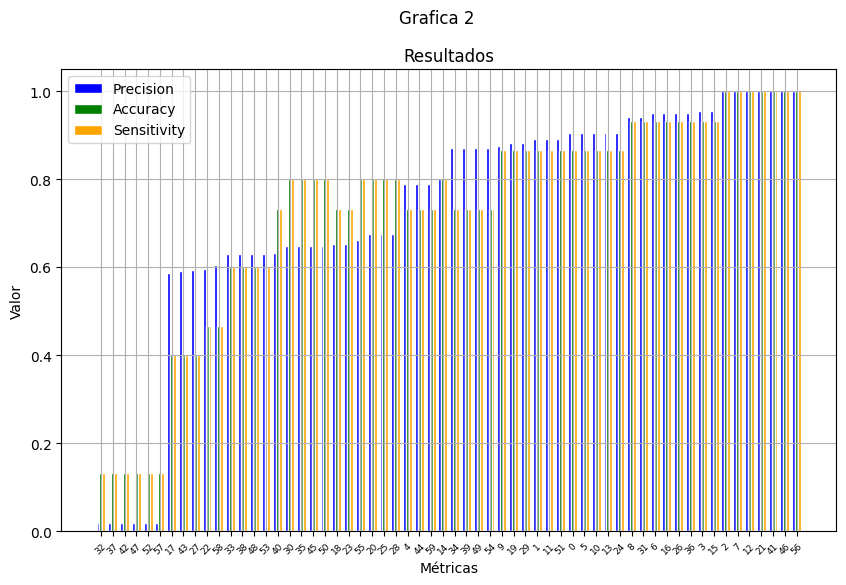

In [58]:
# Configurar los datos para el gráfico
labels = result_table_raw.index
metrics = ['precision', 'accuracy', 'sensitivity']
values = result_table_raw[metrics].values.T

# Configurar el tamaño de la figura
plt.figure(figsize=(10, 6))

# Configurar las posiciones de las barras
bar_width = 0.25
r1 = np.arange(len(labels))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Graficar las barras
plt.bar(r1, values[0], color='blue', width=bar_width, edgecolor='white', label='Precision')
plt.bar(r2, values[1], color='green', width=bar_width, edgecolor='white', label='Accuracy')
plt.bar(r3, values[2], color='orange', width=bar_width, edgecolor='white', label='Sensitivity')

# Configurar los títulos y etiquetas
plt.xlabel('Métricas')
plt.ylabel('Valor')
plt.title('Resultados')
plt.suptitle('Grafica 2')
plt.xticks([r + bar_width for r in range(len(labels))], labels, rotation=45, fontsize=6.5)
plt.grid()
plt.legend()

# Mostrar el gráfico
plt.show()

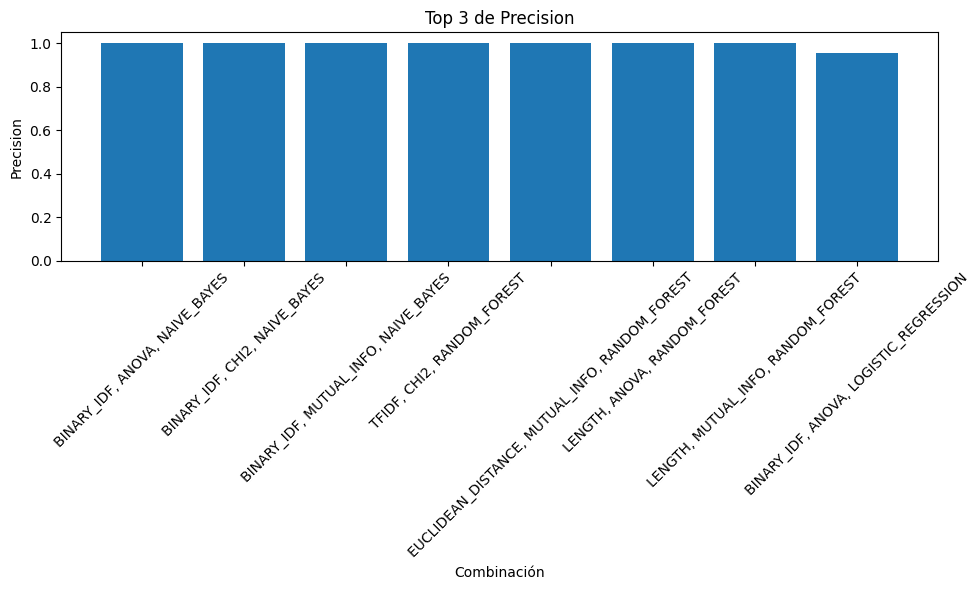

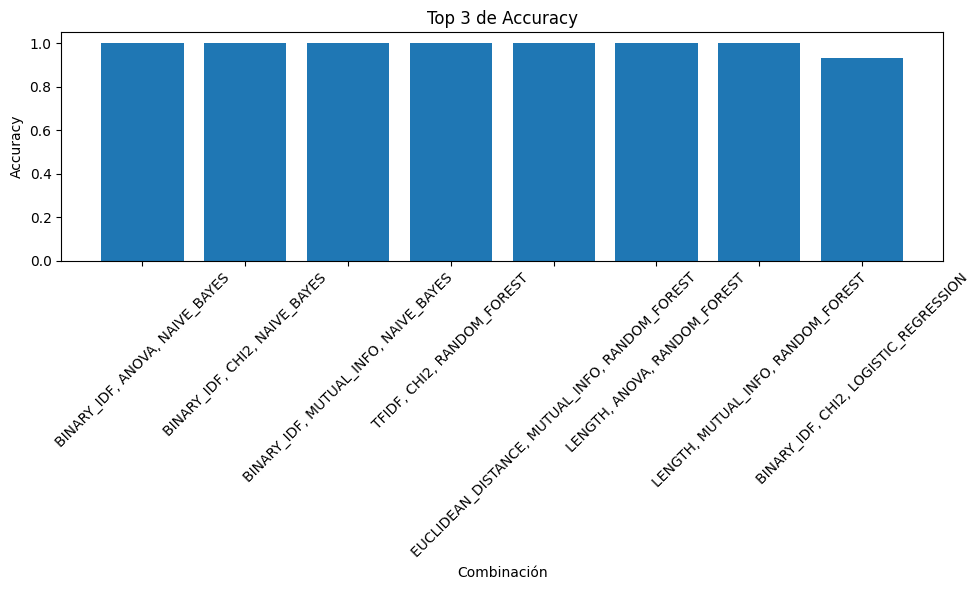

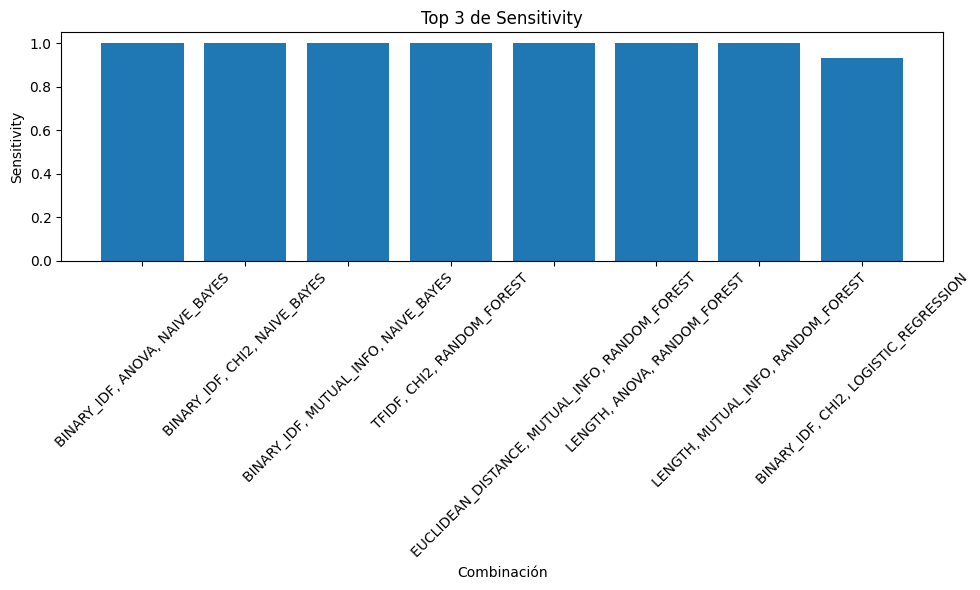

In [68]:
top_precision = result_table_raw.nlargest(8, 'precision')
top_accuracy = result_table_raw.nlargest(8, 'accuracy')
top_sensitivity = result_table_raw.nlargest(8, 'sensitivity')

# Gráfica de precision
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(top_precision)), top_precision['precision'], align='center')
plt.xticks(np.arange(len(top_precision)), top_precision['term_weight'] + ', ' + top_precision['term_selecting'] + ', ' + top_precision['classifier'], rotation=45)
plt.xlabel('Combinación')
plt.ylabel('Precision')
plt.title('Top 3 de Precision')
plt.tight_layout()
plt.show()

# Gráfica de accuracy
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(top_accuracy)), top_accuracy['accuracy'], align='center')
plt.xticks(np.arange(len(top_accuracy)), top_accuracy['term_weight'] + ', ' + top_accuracy['term_selecting'] + ', ' + top_accuracy['classifier'], rotation=45)
plt.xlabel('Combinación')
plt.ylabel('Accuracy')
plt.title('Top 3 de Accuracy')
plt.tight_layout()
plt.show()

# Gráfica de sensitivity
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(top_sensitivity)), top_sensitivity['sensitivity'], align='center')
plt.xticks(np.arange(len(top_sensitivity)), top_sensitivity['term_weight'] + ', ' + top_sensitivity['term_selecting'] + ', ' + top_sensitivity['classifier'], rotation=45)
plt.xlabel('Combinación')
plt.ylabel('Sensitivity')
plt.title('Top 3 de Sensitivity')
plt.tight_layout()
plt.show()

# Discusión Parte 1

 ***Desarrollo***

Para desarrollar esta parte del taller, se tuvo en cuenta parte del preprocesamiento de texto desarrollado en el taller 1, ya que asi se facilita el trabajo de analisis de textos, esto permite a los clasificadores de texto tener menos ruido a la hora de clasificar el texto.

Con el fin de facilitar la comprensión del desarrollo del ejercicio, se creó una clase denominada Combinator. Esta clase se encarga de llevar a cabo la combinación de los elementos claves de las tareas de clasificacion de texto, tiene en cuenta clasificadores, pesos de términos y selectores de términos. La misma incluye métodos que permiten generar todas las posibles combinaciones de estos tres elementos, así como ejecutar dichas combinaciones en un conjunto de datos.

Dentro de la clase, se encuentra un método que se encarga de ejecutar todas las combinaciones de pesos de términos, selectores de términos y clasificadores en el conjunto de datos. Los resultados obtenidos al evaluar el rendimiento de cada combinación son almacenados en un diccionario y posteriormente devueltos como resultado.

## **Discusión**

### Analisis de Resultados

* **Grafica 1**

Existen conjuntos de métodos que consiguen un desempeño ideal, esto mas alla de ser bueno, solo se puede definir como:

* El conjunto de datos es relativamente fácil de clasificar debido a su tamaño.

* La probrbailidad jugó a nuestro favor y se usaron los metodos que son mejores justo en este tipo de tematicas con su combinacion.

* La tarea es muy simple para los clasificadores ya que los temas no son ni ambiguos ni se mezclan entre si.

Los conjuntos que obtuvieron la calificacion perfecta fueron:

* BINARY_IDF	ANOVA	NAIVE_BAYES
* BINARY_IDF	CHI2	RANDOM_FOREST
* BINARY_IDF	CHI2	NAIVE_BAYES
* BINARY_IDF	MUTUAL_INFO	NAIVE_BAYES
* TFIDF	ANOVA	GRADIENT_BOOSTING
* TFIDF	CHI2	GRADIENT_BOOSTING
* TFIDF	MUTUAL_INFO	GRADIENT_BOOSTING
* EUCLIDEAN_DISTANCE	ANOVA	GRADIENT_BOOSTING
* EUCLIDEAN_DISTANCE	MUTUAL_INFO	RANDOM_FOREST
* EUCLIDEAN_DISTANCE	MUTUAL_INFO	GRADIENT_BOOSTING
* LENGTH	ANOVA	GRADIENT_BOOSTING
* LENGTH	CHI2	RANDOM_FOREST
* LENGTH	MUTUAL_INFO	RANDOM_FOREST

Lo cual se puede resumir como:

Las ponderacion que mas aparece (4) es ponderación de términos con IDF binario (BINARY_IDF). El seleccionador que mas se destaca  (5 veces) es   Mutual Information(MUTUAL_INFO). El clasificador que mejor se desempeña (6 veces) es Gradient Boosting.

Es importante destacar que no existe la mezcla de los tres en los mejores, lo cual es llamativo debido a que hace que las formas de análisis sean peculiares y revisar cómo se mezclan los diferentes métodos, se complementan y proporciona un aprendizaje completo. Sin embargo, si observamos la mezcla de estos tres métodos, sus métricas no fueron adecuadas.

BINARY_IDF	MUTUAL_INFO	GRADIENT_BOOSTING	0.855556	0.800000	0.800000	0.939103

Vemos que estan bien pero lejos de un 100%, lo que quiere decir que no son los tipos de ponderacion, seleccion y clasificado si no dado el corpus y como se transmite la informacion entre los metodos.

* **Grafica 2**

Teniendo en cuenta todo el analisis anteiro, de las graficas se obtuvieorn los siguientes resultado:

* BINARY_IDF	ANOVA	NAIVE_BAYES
* BINARY_IDF	CHI2	NAIVE_BAYES
* BINARY_IDF	MUTUAL_INFO	NAIVE_BAYES
* TFIDF	CHI2	RANDOM_FOREST
* EUCLIDEAN_DISTANCE	MUTUAL_INFO	RANDOM_FOREST
* LENGTH	ANOVA	RANDOM_FOREST
* LENGTH	MUTUAL_INFO	RANDOM_FOREST

Siendo los ganadores:
IDF binario (BINARY_IDF), Mutual Information (MUTUAL_INFO) y Random Forest

Aqui se esta trabajando con el texto en crudo, de ahi que se reduzca la cantidad de combinacion pero llaman la atencion dos: TFIDF	CHI2	RANDOM_FOREST y LENGTH	ANOVA	RANDOM_FOREST, los cuales no estaba antes, lo que quiere decir que estos son ideales para tratar el texto crudo, incluso, se puede inferir que random forest aporta gran parte a la gran capcidad de entrenamiento dados los datos.

Esto antes dicho verifica nuestra hipotesis, el comportamiento no esta dado por los metodos si no su mezcla, como se complementan y estan grandemente influenciados por el tiempo de datos.

### En resumen

* El preprocesado es fundamental para mejorar el rendimiento de los clasificadores. Al realizar un preprocesado adecuado mejorara la calidad de los términos utilizados en el análisis y reducir el ruido o la redundancia en los datos. Esto ayuda a los clasificadores a capturar de manera más precisa las características distintivas de cada clase y a tomar decisiones más acertadas.


* La estrategia que mejor funciona depende del texto, es fundamental la eliminacion de stopword ya que es solo ruido para el analisis del texto, pero tareas como lematización y stemming, pueden estar sesgadas al tipo de texto, ya que es mejor hacer una prueba de estrategias de cual metodo se comporta mejor segun el texto.

* Los n-gramas pueden aportar a mejorar las tasas de acierto en ciertos casos, es visibel como Mutual Information(MUTUAL_INFO) se destaco en ambos casos y hace que mejore el comportamiento del modelo, teniendo presente el tipo de dartos.

* Es importante tener tecnicas de normalizacion de longitud de documentos ya que se pueden presentar dos situacion al haber documentos más extensos que otros, estos pueden afectar el entrenamiento y evaluación de los clasificadores. Los documentos más largos pueden contener más información y características, lo que puede ser beneficioso para la clasificación. Sin embargo, también pueden introducir ruido o información irrelevante que puede dificultar la clasificación precisa.

* El desbalanceo de las clases ( o temáticas), es grave ya que  puede afectar el sistema de clasificación de documentos. Si una clase está sobrerrepresentada en comparación con otras y existe ambiguedades en las minoritarias que puedan hacer enfasis en la clase sobrerrepresentada, el clasificador puede tener un sesgo hacia esa clase dominante y tener dificultades para clasificar correctamente las clases minoritarias.

* Cabe aclarar que el resultado esta muy sesgado por el tamaño del corpus, las tematicas de deportes, economia, musica y politica, pueden ser faciles de distinguir o la linea de economia y politica estan muy marcadas sin tantas cosas en comun.

---

---

# Parte 2 - Sentiment Analysis y reconocimiento de emociones

Para el siguiente punto trabajen con un dataset de comentarios en redes sociales o comentarios de clientes sobre productos. Les puedo recomendar alguno de los siguientes datasets de Kaggle.

Respondan las siguientes preguntas:
* ¿Cuales son los diferentes tipos de analisis de sentimientos?
* ¿Cuales son los diferentes metodos para el analisis de sentimientos?
* ¿Cuales son los desafios del analisis de sentimientos?

Desarrollen los siguientes ejercicios:

* Implementen un clasificador de analisis de sentimientos en Python o en Orange a partir de un conjunto de documentos de texto.
* Analicen el sentimiento de un conjunto de publicaciones en redes sociales. Identifiquen tambien las emociones contenidas en las publicaciones.
* Creen un modelo de analisis de sentimientos para un dominio específico, como resenas de peliculas o comentarios de clientes.

## Clases


In [69]:
class OrtographyCorrector:
    def __init__(self, language='es', dictionary_file='diccionario.txt'):
        self.spell = SpellChecker(language=language)
        self.dictionary = self.load_dictionary(dictionary_file)

    def load_dictionary(self, dictionary_file):
        with open(dictionary_file, 'r', encoding='utf-8') as file:
            return file.read().splitlines()

    def correct_sentence(self, sentence):
        words = sentence.split()
        corrected_words = [self.correct_word(word) for word in words]
        return ' '.join(corrected_words)

    def correct_word(self, word):
        if self.spell.correction(word) == word:
            return word
        else:
            suggestions = list(self.spell.candidates(word))
            matched_suggestions = [s for s in suggestions if s in self.dictionary]

            if matched_suggestions:
                corrected_word = random.choice(matched_suggestions)
            else:
                corrected_word = str(suggestions[0])

            return corrected_word

## Desarrollo

In [22]:
df = pd.read_csv('twitter_training.csv',
                       header=None,
                       names=['TweetID', 'Sentiment', 'TweetText'],)

df_train = df.sample(n=1000, random_state=1)
df_train

,TweetID,Sentiment,TweetText
2415,Borderlands,Positive,FICK YESSSSSS.
8319,Microsoft,Negative,Why are people talking about microsoft buying ...
9181,Nvidia,Neutral,Nvidia's ready to announce the bad stuff.. Rea...
7841,MaddenNFL,Negative,Gee. I didn't realize Madden NFL needed QBs fo...
575,ApexLegends,Positive,The game is an absolute shredder!!!
...,...,...,...
5048,GrandTheftAuto(GTA),Positive,It's about fricking time!
9427,Overwatch,Negative,"Initially, I didn't like the idea, but I would..."
1653,CallOfDutyBlackopsColdWar,Positive,This video has only brought back good memories...
1675,CallOfDutyBlackopsColdWar,Neutral,The very best and the game isn’t out yet


In [23]:
sentiment_analysis = pipeline(task="sentiment-analysis",
                              framework="pt",
                              model="j-hartmann/sentiment-roberta-large-english-3-classes")

Some weights of the model checkpoint at j-hartmann/sentiment-roberta-large-english-3-classes were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [24]:
df_train['TweetText'] = df_train['TweetText'].astype(str)
df_train['Sentiment'] = df_train['Sentiment'].str.lower()
list_text = df_train['TweetText'].tolist()

In [25]:
results = sentiment_analysis(list_text)
df_train['HuggingFace_Sentiment'] = [result['label'] for result in results]

In [26]:
sia = SentimentIntensityAnalyzer()
def get_sentiment_label(score):
    if score > 0.05:
        label = 'positive'
    elif score < -0.05:
        label = 'negative'
    else:
        label = 'neutral'
    return label

df_train['nltk_sentiment'] = df_train['TweetText'].apply(
    lambda x: get_sentiment_label(sia.polarity_scores(x)['compound']))

In [27]:
# Normalizacion y limpieza
df_train['TweetText'] = df_train['TweetText'].str.lower()

def remove_symbols(text, regex):
    return re.sub(regex, '', text)

df_train['TweetText'] = df_train['TweetText'].apply(lambda x: remove_symbols(x, r'[^\w\s]'))
df_train['TweetText'] = df_train['TweetText'].apply(lambda x: remove_symbols(x, r'\d+'))
df_train['TweetText'] = df_train['TweetText'].str.lower()
print(df_train)

                        TweetID Sentiment  \
2415                Borderlands  positive   
8319                  Microsoft  negative   
9181                     Nvidia   neutral   
7841                  MaddenNFL  negative   
575                 ApexLegends  positive   
...                         ...       ...   
5048        GrandTheftAuto(GTA)  positive   
9427                  Overwatch  negative   
1653  CallOfDutyBlackopsColdWar  positive   
1675  CallOfDutyBlackopsColdWar   neutral   
3834              Cyberpunk2077  positive   

                                              TweetText HuggingFace_Sentiment  \
2415                                      fick yessssss              positive   
8319  why are people talking about microsoft buying ...              negative   
9181  nvidias ready to announce the bad stuff really...              negative   
7841  gee i didnt realize madden nfl needed qbs for ...              negative   
575                    the game is an absolute shredde

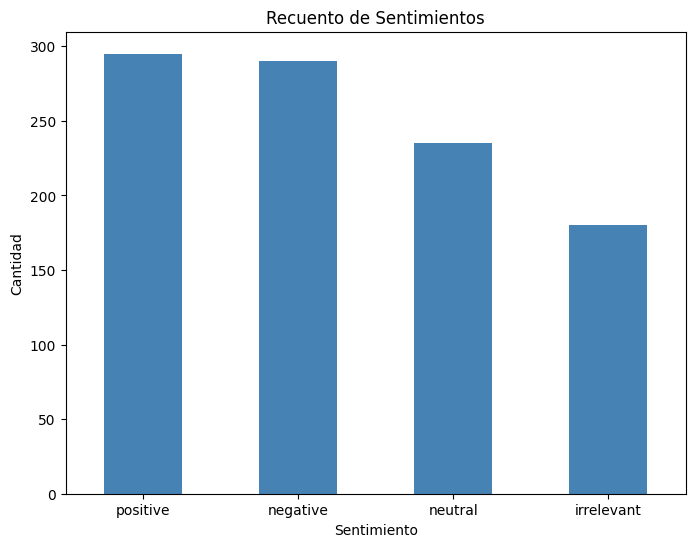

In [28]:
# Realizar el recuento de las etiquetas de sentimiento
sentiment_counts = df_train['Sentiment'].value_counts()

# Configurar el tamaño de la figura
plt.figure(figsize=(8, 6))

# Graficar las barras
sentiment_counts.plot(kind='bar', color='steelblue')

# Configurar los títulos y etiquetas
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad')
plt.title('Recuento de Sentimientos')
plt.xticks(rotation=0)

# Mostrar el gráfico
plt.show()

In [29]:
df_train['TweetText'] = df_train['TweetText'].astype(str)
list_text = df_train['TweetText'].tolist()
results = sentiment_analysis(list_text)
df_train['Preprocessing+HuggingFace_Sentiment'] = [result['label'] for result in results]

In [30]:
def get_sentiment_label(score):
    if score > 0.05:
        label = 'positive'
    elif score < -0.05:
        label = 'negative'
    else:
        label = 'neutral'
    return label

df_train['Preprocessing+nltk_sentiment'] = df_train['TweetText'].apply(
    lambda x: get_sentiment_label(sia.polarity_scores(x)['compound']))

In [31]:
metricas = ModelMetrics()

df_metrics = {'Precision': [], 'Exactitud': [], 'Sensibilidad': [], 'Especificidad': []}
for pred in [df_train['HuggingFace_Sentiment'],
             df_train['nltk_sentiment'],
             df_train['Preprocessing+HuggingFace_Sentiment'],
             df_train['Preprocessing+nltk_sentiment']]:
    df_metrics['Precision'].append(metricas.precision(df_train['Sentiment'], pred))
    df_metrics['Exactitud'].append(metricas.accuracy(df_train['Sentiment'], pred))
    df_metrics['Sensibilidad'].append(metricas.recall(df_train['Sentiment'], pred))
    df_metrics['Especificidad'].append(metricas.specificity(df_train['Sentiment'], pred))
df_metrics = pd.DataFrame(df_metrics, index=['HuggingFace',
                                             'NLTK',
                                             'HuggingFace+Preprocessing',
                                             'NLTK+Preprocessing'])
df_metrics

 [22-Jun-23 04:27:36] [INFO] [ModelMetrics]  =>>>   Calculating precision
 [22-Jun-23 04:27:36] [INFO] [ModelMetrics]  =>>>   Calculating accuracy
 [22-Jun-23 04:27:36] [INFO] [ModelMetrics]  =>>>   Calculating recall
 [22-Jun-23 04:27:36] [INFO] [ModelMetrics]  =>>>   Calculating specificity
 [22-Jun-23 04:27:36] [INFO] [ModelMetrics]  =>>>   Calculating precision
 [22-Jun-23 04:27:36] [INFO] [ModelMetrics]  =>>>   Calculating accuracy
 [22-Jun-23 04:27:36] [INFO] [ModelMetrics]  =>>>   Calculating recall
 [22-Jun-23 04:27:36] [INFO] [ModelMetrics]  =>>>   Calculating specificity
 [22-Jun-23 04:27:36] [INFO] [ModelMetrics]  =>>>   Calculating precision
 [22-Jun-23 04:27:36] [INFO] [ModelMetrics]  =>>>   Calculating accuracy
 [22-Jun-23 04:27:36] [INFO] [ModelMetrics]  =>>>   Calculating recall
 [22-Jun-23 04:27:36] [INFO] [ModelMetrics]  =>>>   Calculating specificity
 [22-Jun-23 04:27:36] [INFO] [ModelMetrics]  =>>>   Calculating precision
 [22-Jun-23 04:27:36] [INFO] [ModelMetrics] 

,Precision,Exactitud,Sensibilidad,Especificidad
HuggingFace,0.512,0.512,0.512,0.833519
NLTK,0.405,0.405,0.405,0.793585
HuggingFace+Preprocessing,0.496,0.496,0.496,0.827797
NLTK+Preprocessing,0.409,0.409,0.409,0.794667


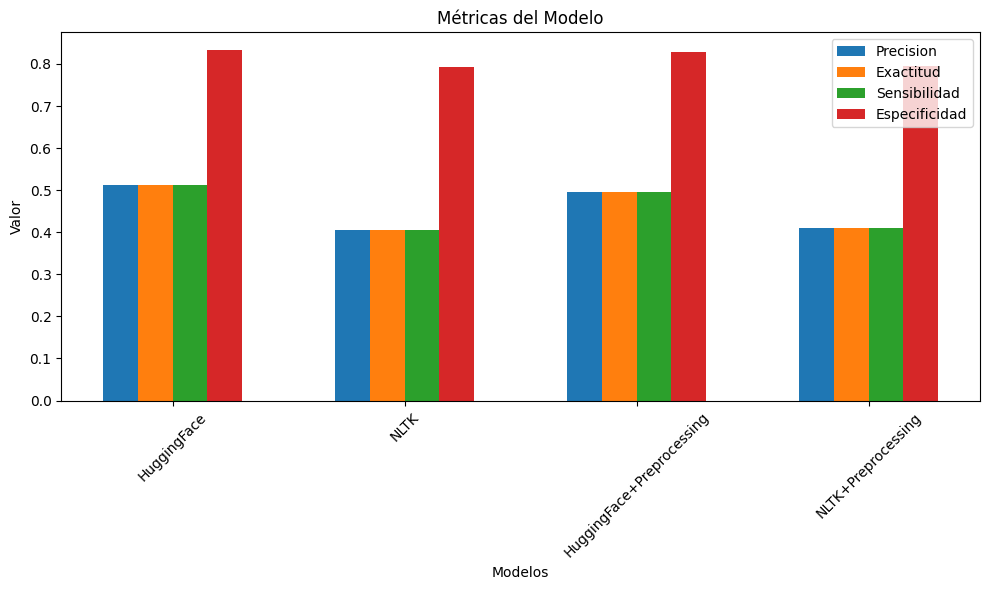

In [32]:
# Configurar el tamaño de la figura
plt.figure(figsize=(10, 6))

# Configurar los datos para el gráfico
labels = df_metrics.index
metrics = df_metrics.columns
values = df_metrics.values.T

# Configurar las posiciones de las barras
bar_width = 0.15
r = [0, 1, 2, 3]

# Graficar las barras para cada métrica
for i in range(len(metrics)):
    plt.bar([x + (i * bar_width) for x in r], values[i], width=bar_width, label=metrics[i])

# Configurar los títulos y etiquetas
plt.xlabel('Modelos')
plt.ylabel('Valor')
plt.title('Métricas del Modelo')
plt.xticks([r + (bar_width * 1.5) for r in range(len(labels))], labels, rotation=45)
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [87]:
# Lee el archivo CSV
df1 = pd.read_csv("Reddit_Data.csv", delimiter=',', header=0, nrows = 100)
df1.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [90]:
# Convierte las columnas a tipo str en el DataFrame
df1 = df1.astype(str)

# Convierte las columnas en una lista
listValue = df1['clean_comment'].tolist()
print(listValue)

sentiment_pipeline = pipeline("sentiment-analysis")
sentiment_pipeline(listValue)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[' family mormon have never tried explain them they still stare puzzled from time time like some kind strange creature nonetheless they have come admire for the patience calmness equanimity acceptance and compassion have developed all the things buddhism teaches ', 'buddhism has very much lot compatible with christianity especially considering that sin and suffering are almost the same thing suffering caused wanting things shouldn want going about getting things the wrong way christian this would mean wanting things that don coincide with god will and wanting things that coincide but without the aid jesus buddhism could also seen proof god all mighty will and omnipotence certainly christians are lucky have one such christ there side but what about everyone else well many christians believe god grace salvation and buddhism god way showing grace upon others would also help study the things jesus said and see how buddha has made similar claims such rich man getting into heaven joke basica

[{'label': 'POSITIVE', 'score': 0.9873688817024231},
 {'label': 'NEGATIVE', 'score': 0.9784723520278931},
 {'label': 'NEGATIVE', 'score': 0.8356412649154663},
 {'label': 'NEGATIVE', 'score': 0.8713164925575256},
 {'label': 'POSITIVE', 'score': 0.9957512617111206},
 {'label': 'POSITIVE', 'score': 0.583972692489624},
 {'label': 'POSITIVE', 'score': 0.8980887532234192},
 {'label': 'POSITIVE', 'score': 0.7548344135284424},
 {'label': 'POSITIVE', 'score': 0.9854493737220764},
 {'label': 'NEGATIVE', 'score': 0.9863309860229492},
 {'label': 'POSITIVE', 'score': 0.9996017813682556},
 {'label': 'POSITIVE', 'score': 0.8667024970054626},
 {'label': 'POSITIVE', 'score': 0.7947589159011841},
 {'label': 'NEGATIVE', 'score': 0.9749019145965576},
 {'label': 'POSITIVE', 'score': 0.9886032342910767},
 {'label': 'NEGATIVE', 'score': 0.9852328896522522},
 {'label': 'NEGATIVE', 'score': 0.9885879755020142},
 {'label': 'NEGATIVE', 'score': 0.9831384420394897},
 {'label': 'POSITIVE', 'score': 0.9783162474632

**Segundo punto, analisis de emociones en redes sociales.**

Para el analisis de emociones se declara un pipeline dintinto en la librería transformers de la siguiente manera

In [91]:
#Modelo de analisisd de emociones
classifier1  = pipeline("sentiment-analysis", model="michellejieli/emotion_text_classifier")

classifier1(listValue)

[{'label': 'neutral', 'score': 0.9273881316184998},
 {'label': 'neutral', 'score': 0.6027140617370605},
 {'label': 'neutral', 'score': 0.8580102920532227},
 {'label': 'neutral', 'score': 0.7800423502922058},
 {'label': 'neutral', 'score': 0.7877883315086365},
 {'label': 'neutral', 'score': 0.915410041809082},
 {'label': 'sadness', 'score': 0.5280075669288635},
 {'label': 'neutral', 'score': 0.9694218635559082},
 {'label': 'neutral', 'score': 0.9473558664321899},
 {'label': 'neutral', 'score': 0.6374954581260681},
 {'label': 'neutral', 'score': 0.7253219485282898},
 {'label': 'neutral', 'score': 0.8786347508430481},
 {'label': 'neutral', 'score': 0.874238133430481},
 {'label': 'neutral', 'score': 0.8946846723556519},
 {'label': 'joy', 'score': 0.7078987956047058},
 {'label': 'neutral', 'score': 0.8747259378433228},
 {'label': 'anger', 'score': 0.44495946168899536},
 {'label': 'neutral', 'score': 0.9525309801101685},
 {'label': 'neutral', 'score': 0.9768503904342651},
 {'label': 'neutral

In [92]:
#Modelo de analisisd de emociones
classifier2  = pipeline("text-classification",model='bhadresh-savani/distilbert-base-uncased-emotion', return_all_scores=True)

classifier2(listValue)

[[{'label': 'sadness', 'score': 0.0013895600568503141},
  {'label': 'joy', 'score': 0.0010682872962206602},
  {'label': 'love', 'score': 0.0006878719432279468},
  {'label': 'anger', 'score': 0.002192028099671006},
  {'label': 'fear', 'score': 0.8384852409362793},
  {'label': 'surprise', 'score': 0.1561770737171173}],
 [{'label': 'sadness', 'score': 0.0013362165773287416},
  {'label': 'joy', 'score': 0.99446702003479},
  {'label': 'love', 'score': 0.0013964440440759063},
  {'label': 'anger', 'score': 0.0019376211566850543},
  {'label': 'fear', 'score': 0.0003880284202750772},
  {'label': 'surprise', 'score': 0.00047482334775850177}],
 [{'label': 'sadness', 'score': 0.07000868022441864},
  {'label': 'joy', 'score': 0.06596077233552933},
  {'label': 'love', 'score': 0.0031755731906741858},
  {'label': 'anger', 'score': 0.3817349970340729},
  {'label': 'fear', 'score': 0.3446924090385437},
  {'label': 'surprise', 'score': 0.13442759215831757}],
 [{'label': 'sadness', 'score': 0.40219190716

In [157]:
# Ruta al archivo de texto

df4= pd.read_csv('/content/test.ft.txt', sep='\t', header=None)

# Dividir la primera columna en etiqueta y texto
df4['Etiqueta'] = df4.iloc[:, 0].str.extract(r'(__label__\d+)')
df4['Texto'] = df4[0].str.replace(r'(__label__\d+\s*)', '')
df4['Texto'] = df4['Texto'].str.replace('__label__1', '').str.replace('__label__2', '')
# Eliminar la columna original
df4.drop(columns=[0], inplace=True)

# Mostrar el DataFrame resultante
print(df4)

        Etiqueta                                              Texto
0     __label__2   Great CD: My lovely Pat has one of the GREAT ...
1     __label__2   One of the best game music soundtracks - for ...
2     __label__1   Batteries died within a year ...: I bought th...
3     __label__2   works fine, but Maha Energy is better: Check ...
4     __label__2   Great for the non-audiophile: Reviewed quite ...
...          ...                                                ...
2995  __label__1   Please no more!: The third installment of Cro...
2996  __label__1   Not the Buddy Holly I know and love: My husba...
2997  __label__1   Pathetic movie feels like a made for TV movie...
2998  __label__2   Amazing: Camus's novel truley symbolizes the ...
2999  __label__2   read it for your own reaction.: This novel is...

[3000 rows x 2 columns]


In [158]:
# Preprocesamiento de texto
def preprocess_text(text):
    # Eliminar caracteres especiales y números
    text = re.sub(r'[^a-zA-Z]', ' ', text)

    # Convertir el texto a minúsculas
    text = text.lower()

    # Eliminar stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])

    # Lematización
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    return text

# Aplicar preprocesamiento a los datos
df4['texto_preprocesado'] = df4['Texto'].apply(preprocess_text)

# Dividir los datos en conjunto de entrenamiento y prueba
train_data, test_data, train_labels, test_labels = train_test_split(df4['texto_preprocesado'], df4['Etiqueta'], test_size=0.2, random_state=42)

In [159]:
#Construcción y entrenamiento del modelo con Naive Bayes
# Crear instancia del vectorizador TF-IDF
vectorizer = TfidfVectorizer()

# Ajustar y transformar los datos de entrenamiento
train_features = vectorizer.fit_transform(train_data)

# Transformar los datos de prueba
test_features = vectorizer.transform(test_data)

# Crear instancia del clasificador Naive Bayes
classifier = MultinomialNB()

# Entrenar el clasificador
classifier.fit(train_features, train_labels)

MultinomialNB()

In [160]:
#Evaluación del modelo:
# Realizar predicciones en los datos de prueba
predictions = classifier.predict(test_features)

# Calcular la precisión del modelo
accuracy = accuracy_score(test_labels, predictions)
print("Precisión del modelo: ", accuracy)

Precisión del modelo:  0.8266666666666667


In [161]:
#Uso del modelo
# Ejemplo de predicción con nuevos datos
new_comments = ["This product is amazing", "I did not like the product, it has many defects"]

# Preprocesar los nuevos comentarios
preprocessed_comments = [preprocess_text(comment) for comment in new_comments]

# Transformar los nuevos comentarios en características TF-IDF
new_features = vectorizer.transform(preprocessed_comments)

# Realizar predicciones en los nuevos comentarios
new_predictions = classifier.predict(new_features)
# Mostrar las predicciones
for comment, prediction in zip(test_features, new_predictions):
    print("Comentario:", comment)
    print("Sentimiento:", prediction)
    print()

Comentario:   (0, 13051)	0.3114965324194435
  (0, 12544)	0.2535872221319724
  (0, 11698)	0.14710656486973664
  (0, 11194)	0.1460443857972565
  (0, 9306)	0.1541801133189691
  (0, 8974)	0.22096494165076958
  (0, 8272)	0.18756482563450405
  (0, 8209)	0.17806033013369676
  (0, 6889)	0.14792288271631138
  (0, 6888)	0.19248660851065524
  (0, 6073)	0.15755961034296204
  (0, 5618)	0.1516750641615066
  (0, 5587)	0.17687557359549433
  (0, 4923)	0.17687557359549433
  (0, 4029)	0.16995326026084168
  (0, 4011)	0.20988873610878112
  (0, 3484)	0.2762179194841231
  (0, 3143)	0.21746238723248648
  (0, 1829)	0.1413643221912795
  (0, 1815)	0.21582377613283457
  (0, 1306)	0.33518092147294176
  (0, 1286)	0.2519217256940788
  (0, 357)	0.1299992814652674
  (0, 114)	0.17629659201633185
Sentimiento: __label__2

Comentario:   (0, 13170)	0.11866873586199322
  (0, 11362)	0.12328375140716506
  (0, 11315)	0.158286866245249
  (0, 10957)	0.07721606982852133
  (0, 10798)	0.10754922123213267
  (0, 10734)	0.093672872989

# Discusión Parte 2


**Los diferentes tipos de analisis son:**

* Basado en lexicons: Este enfoque utiliza  grandes diccionarios de palabras predefinidos a las que se le asignan polaridades o etiquetas de sentimiento a las palabras. Se calcula el sentimiento general de un documento sumando las polaridades de las palabras presentes en él.

* Basado en Machine Learning: Estos modelos aprenden a reconocer patrones y características lingüísticas que indican sentimientos positivos, negativos o neutros, a partir de bases de datos etiquetadas y entrenando modelos.

* Basado en reglas: contiene reglas específicas para determinar la opinión o sentimiento de un documento, estas puede tener patrones gramaticales, bigramas, palabras clave, diferentes puntos que identifican la emocion.

**Diferentes metodos para el analisis de sentimientos**

Dentro del los diferentes metodos se pueden agrupar los diferentes ripos de analisis, estando presente:

* Análisis léxico
* Aprendizaje automático supervisado
*  Enfoques híbrido
* Comparacion de reglas de sentimientos en patornes y problemas especificos.

**Desafios del analisis de sentimientos**

Para el analisis de sentimientos es un problema reconocer sarcasmos y comentarios subjetivos, ya que se pueden entender dintintas intenciones de una frase.

Casos dificiles para el analisis de sentimientos podría darse al momento de analizar una frase extensa donde incuyan contradicciones de calificación, esto se podría encontrar cuando describen positivamente a un producto pero al final decribe un aspecto clave que invalida los enterior.

Otros retos es el analisis de:

* Ambigüedad:  interpretación del sentimiento puede ser complicada cuando las expresiones son ambiguas
* Subjetividad y variabilidad: La interpretación de sentimientos puede ser subjetiva y variar entre diferentes personas. incluso la cultura.
* Análisis de contexto dependiendo del lugar, la situacion o el idioma una palabra puede variar y estar sesgada a un tipo de sentimiento de una region.
* Expresiones idiomáticas y jerga: Las expresiones idiomáticas y la jerga pueden dificultar la identificación precisa del sentimiento, ya que pueden tener significados figurados o connotaciones de segundo sentido, ironias.

# Resultados

En el caso específico de esta base de datos y los resultados de la primera tabla, se observa una falta de métricas satisfactorias. Sin embargo, es importante tener en cuenta que estas métricas generadas representan un promedio de las cuatro etiquetas generadas. Es necesario realizar un análisis exhaustivo para determinar qué etiquetas se identifican mejor las tematicas de los tweets. Además, se puede considerar la utilización de un corrector ortográfico para evaluar su impacto en el rendimiento. Asimismo, se pueden aplicar tecnicas de preprocesamiento, incluyendo etiquetar los emoticones, esto genera una gran relevancia sobre el sentimiento de la frase mas alla de su analisis gramatical y literal.

En la implementacion del segundo punto se usaron dos pipeline, el primero con menor informacion que el segundo, aunque el primero tiene resultados precarios el segundo con mayor informacion del analisis de emociones es mejor a que tiene una mayor precisión que en anterior, sin embargo, presenta el analisis de una manera compleja y mas detallada de lo necesario.

Se creao un modelo de analisis para comentarios de productos en Amazon, se uso Representación de características con TF-IDF y de clasificador se entreno con el modelo con Naive Bayes, al evaluarlo la precisin deo modelo usanod la libreria from sklearn.metrics import accuracy_score, fue del 0.8266666666666667, lo que quiere decir que su desempeño fue bueno dada la robustes de los datos, ademas de esto al evaluar el modelo con nuevos datos la clasificación de ambos comentarios basicos fue predicha correctamente.



# Parte 3 - Identificacion de tematicas

Para el siguiente punto trabajen con los documentos contenidos en el archivo <docs parte 2.zip>. Alli encontraran 11 archivos en formato PDF (4 de ellos sobre EEG, 3 sobre motores y 4 sobre PLN). Si trabajan en Orange, estos archivos PDF se pueden cargar directamente con el widget Import Documents del menu ́text Mining. Si van a trabajar en python, echenle un vistazo a las librerIas PyPDF2 (instruccion para Colab: !pip install PyPDF2) y a PDFMINER.SIX (instruccion para Colab:!pip install pdfminer.six).

Implementen un sistema de clasificación no supervisada de documentos. Pueden optar por hacerlo mediante LSI, LDA u cualquier otra técnica que ustedes consideren. Determinen cuál sería el número óptimo de temáticas a considerar a partir de una de las métricas vistas en clase (i.e. topic coherence por medida extrínseca o intrínseca). ¿Creen ustedes que la mejor agrupación sólo reunirá documentos similares? Justifiquen.

Al igual que en el punto anterior, es importante que ustedes analicen MUY BIEN los resultados. Se dará más peso a la evaluación de las conclusiones que a la implementación de los códigos. Es importante que ustedes:

* Apliquen distintas técnicas de preprocesamiento de textos con el fin de mejorar la clasificación final.
* Comparen distintas técnicas de agrupamiento y analicen si los términos y documentos más probables en cada temática sí guardan coherencia con las temáticas originales (EEG, motores y PLN).


##Clases y funciones

In [34]:
#Carga archivos PDF y extrae el texto de cada archivo.
def load_PDF(files):
    """
    Carga archivos PDF y extrae el texto de cada archivo.

    Args:
        files (list): Lista de nombres de archivos.

    Returns:
        dict: Un diccionario que contiene el nombre del archivo como clave y el texto extraído como valor.
    """
    papers = dict()

    # Patrón para el preprocesamiento básico
    pattern = r'[^a-zA-Z-_*.\s]|\n'

    for paper in files:
        if paper.find(".pdf") != -1:
            doc = extract_text("/content/Docs_para_classif/" + str(paper))
            pre_doc = re.sub(pattern, '', doc)
            papers.update({str(paper): pre_doc})
        else:
            print(f"Se evitó cargar un archivo llamado {paper}")

    return papers

#Realiza el preprocesamiento del texto, incluyendo tokenización, eliminación de stopwords y reducción de palabras a su raíz.
def preprocess_text(doc_set):
    """
    Realiza el preprocesamiento del texto: tokenización, eliminación de stopwords y reducción de palabras a su raíz.

    Args:
        doc_set (list): Lista de documentos.

    Returns:
        list: Texto preprocesado.
    """
    # Tokenizador
    tokenizer = RegexpTokenizer(r'\w+')
    # Crear lista de stopwords en inglés
    en_stopW = stopwords.words('english')
    en_stopW.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '-', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'www', '...', 'fig',
                    'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come', 'et', 'al'])
    en_stopW = set(stopwords.words('english'))
    # Crear el objeto p_stemmer de la clase PorterStemmer
    p_stemmer = PorterStemmer()

    # Lista para almacenar los documentos tokenizados
    texts = []
    # Recorrer la lista de documentos
    for i in doc_set:
        # Limpiar y tokenizar el documento
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)  # op1
        tok = word_tokenize(raw)  # op2
        # Eliminar las stopwords de los tokens
        stopped_tokens = [i for i in tok if not i in en_stopW]
        # Reducir las palabras a su raíz
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # Guardar las palabras que tengan más de una letra
        process_doc = [
            stemmed_tokens for stemmed_tokens in stemmed_tokens if len(stemmed_tokens) > 2]
        # Agregar los tokens a la lista
        texts.append(process_doc)

    return texts

#Crea el diccionario de términos del corpus y convierte la lista de documentos en una matriz de términos del documento.
def prepare_corpus(doc_clean):
    """
    Crea el diccionario de términos del corpus y convierte la lista de documentos en una matriz de términos del documento.

    Args:
        doc_clean (list): Lista de documentos preprocesados.

    Returns:
        tuple: Diccionario de términos y matriz de términos del documento.
    """
    # Crear el diccionario de términos del corpus, donde cada término único se le asigna un índice.
    dictionary = corpora.Dictionary(doc_clean)
    # Convertir la lista de documentos en una matriz de términos del documento utilizando el diccionario preparado anteriormente.
    corpus = [dictionary.doc2bow(doc) for doc in doc_clean]

    return dictionary, corpus

# Entrena y devuelve un modelo de LDA (Latent Dirichlet Allocation).
def LDA_model(dictionary, corpus, number_of_topics, words=10, show=False):
    """
    Entrena y devuelve un modelo de LDA (Latent Dirichlet Allocation).

    Args:
        dictionary: Diccionario de términos.
        corpus: Matriz de términos del documento.
        number_of_topics: Número de temas.
        words (int): Número de palabras a mostrar por cada tema.
        show (bool): Indica si mostrar los temas.

    Returns:
        model: Modelo de LDA entrenado.
    """
    # Modelo LDA
    ldamodel = LdaModel(corpus, num_topics=number_of_topics, id2word=dictionary)  # Entrenar el modelo
    if show:
        print(ldamodel.print_topics(num_topics=number_of_topics, num_words=words))

    return ldamodel

#Entrena y devuelve un modelo de LSI (Latent Semantic Indexing).
def LSI_model(dictionary, corpus, number_of_topics, words=50, show=False):
    """
    Entrena y devuelve un modelo de LSI (Latent Semantic Indexing).

    Args:
        dictionary: Diccionario de términos.
        corpus: Matriz de términos del documento.
        number_of_topics: Número de temas.
        words: Número de palabras a mostrar por cada tema.
        show: Indica si mostrar los temas.

    Returns:
        model: Modelo de LSI entrenado.
    """
    # Modelo LSI
    lsimodel = LsiModel(corpus, num_topics=number_of_topics, id2word=dictionary)  # Entrenar el modelo
    if show:
        print(lsimodel.print_topics(num_topics=number_of_topics, num_words=words))

    return lsimodel

#Calcula los valores de coherencia para varios números de temas y modelos (LDA o LSI)
def compute_coherence_values(doc_clean, function, stop, start=2, step=3, words=50):
    """
    Calcula los valores de coherencia para varios números de temas.

    Args:
        doc_clean: Documentos limpios.
        function: Modelo a utilizar ('LDA' o 'LSI').
        stop: Número máximo de temas.
        start: Número inicial de temas.
        step: Incremento de temas.
        words: Número de palabras por cada tema.

    Returns:
        tuple: Lista de modelos y valores de coherencia correspondientes al modelo LDA con el número de temas respectivo.
    """
    dictionary, corpus = prepare_corpus(doc_clean)

    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        if function == 'LDA':
            model = LDA_model(dictionary, corpus, number_of_topics=num_topics, words=words)
        elif function == 'LSI':
            model = LSI_model(dictionary, corpus, number_of_topics=num_topics, words=words)
        else:
            raise Exception('El modelo seleccionado no está definido')

        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_uci')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

#Grafica los valores de coherencia en función del número de temas para un modelo específico.
def plot_graph(doc_clean, function, start, stop, step):
    """
    Grafica los valores de coherencia en función del número de temas.

    Args:
        doc_clean: Documentos limpios.
        function: Modelo a utilizar ('LDA' o 'LSI').
        start: Número inicial de temas.
        stop: Número máximo de temas.
        step: Incremento de temas.
    """
    dictionary, doc_term_matrix = prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(doc_clean, function, stop, start, step)
    # Definir la figura
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.title('Coherencia con modelo ' + function)
    plt.xlabel("Número de temas")
    plt.ylabel("Puntuación de coherencia")
    plt.legend(("Valores de coherencia"), loc='best')
    plt.show()

## Desarrollo



In [35]:
# Obtiene la lista de nombres de archivos en el directorio '/content/Docs_para_classif'
files = os.listdir('/content/Docs_para_classif')

# Imprime la lista de nombres de archivos
print(files)

# Carga y procesa los archivos PDF en la lista 'files'
papers = load_PDF(files)

# Imprime el diccionario 'papers'
papers

['EEG01.pdf', 'EEG03.pdf', 'MOT03.pdf', 'NLP04.pdf', 'MOT01.pdf', 'EEG04.pdf', 'MOT02.pdf', 'NLP02.pdf', 'EEG02.pdf', 'NLP01.pdf', 'NLP03.pdf']


{'EEG01.pdf': 'Journal of Neuroscience Methods   Contents lists available at ScienceDirectJournal of Neuroscience Methodsjournal homepage www.elsevier.comlocatejneumethInvited reviewClinical implication of high-density EEG sleep recordings in ParkinsonsdiseaseTNinfa Amatoa Serena Caverzasioab Salvatore Galatiab*a Parkinsons Disease and Movement Disorders Center Neurocenter of Southern Switzerland - Institute of Clinical Neuroscience of Southern Switzerland LuganoSwitzerlandb Faculty of Biomedical Sciences University of Southern Switzerland Lugano SwitzerlandA R T I C L E I N F OA B S T R A C TKeywordsParkinsons diseaselevodopa-induced dyskinesianon-motor symptomssleep disordersprognostic toolspolysomnographyThe diagnosis of Parkinsons disease PD is made relatively late in the pathological process when already mostof the dopaminergic synapses have died. The evidence showed that at the time of the clinical diagnosis whichcan be done only after motor symptoms appearance the pathogenetic p

In [36]:
#pasa como argumento los valores del diccionario
preprocess = preprocess_text(papers.values())

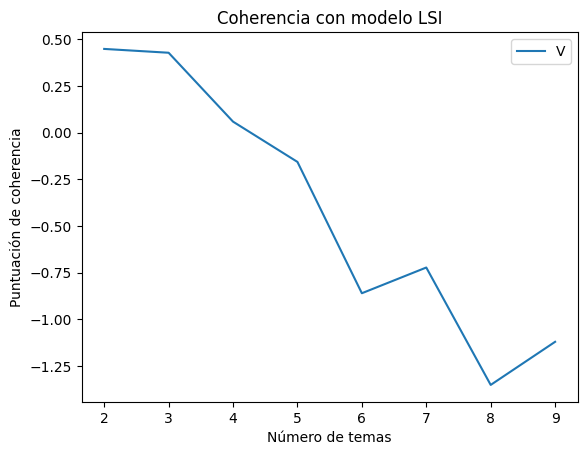

In [37]:
# Variables inicio paso y parar
start, stop, step = 2, 10, 1

# Genera la gráfica usando LSI
plot_graph(preprocess, 'LSI', start, stop, step)

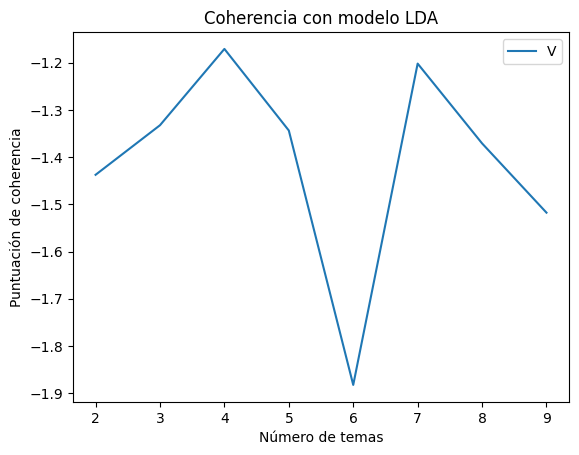

In [38]:
# Genera la gráfica usando LDA
plot_graph(preprocess, 'LDA', start, stop, step)

In [39]:
# Visualizar los temas
pyLDAvis.enable_notebook()

num_topics = 3
LDAvis_data_filepath = os.path.join('/content/ldavis_prepared_' + str(num_topics))

# Construir el modelo LDA
dictionary, corpus = prepare_corpus(preprocess)
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics)
doc_lda = lda_model[corpus]

# Preparar los datos para pyLDAvis
LDAvis_prepared = gensimvis.prepare(lda_model, corpus, dictionary)

# Guardar los datos preparados de pyLDAvis en disco
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

# Cargar los datos preparados de pyLDAvis desde el disco
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

# Guardar la visualización de pyLDAvis en un archivo HTML
pyLDAvis.save_html(LDAvis_prepared, '/content/ldavis_prepared_' + str(20) + '.html')

# Imprimir los datos preparados de pyLDAvis
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.006082 -0.000083       1        1  36.808316
2     -0.003157 -0.003205       2        1  32.147778
1     -0.002924  0.003288       3        1  31.043907, topic_info=          Term        Freq       Total Category  logprob  loglift
6328     fusel  246.000000  246.000000  Default  30.0000  30.0000
3243      fuel  630.000000  630.000000  Default  29.0000  29.0000
90       alpha   71.000000   71.000000  Default  28.0000  28.0000
56       activ  110.000000  110.000000  Default  27.0000  27.0000
2184    inform   94.000000   94.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
3727       oil   56.837270  282.061430   Topic3  -5.9324  -0.4322
1209   patient   45.101668  155.494768   Topic3  -6.1636  -0.0679
1303   process   42.616003  135.564740   Topic3  -6.2203   0.0125
684     higher   42.509561  138.999366   Topic3  -6.2228  -0.0150
1384  research   41.751966  129.578595   Topic3  -6.2408   0.0372

[261 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
3          1  0.443244        ...
3          2  0.300042        ...
3          3  0.259127        ...
13941      1  0.309062       .cid
13941      2  0.309062       .cid
...      ...       ...        ...
2589       2  0.317302  weintraub
2589       3  0.317302  weintraub
7355       1  0.529392     yilmaz
7355       2  0.264696     yilmaz
7355       3  0.132348     yilmaz

[543 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

In [40]:
# Crear el diccionario y el corpus
dictionary, corpus = prepare_corpus(preprocess)

# Entrenar el modelo LDA
ldamodel = LDA_model(dictionary, corpus, number_of_topics=3)

In [41]:
# Obtener los temas de todos los documentos
all_topics = ldamodel.get_document_topics(corpus)
all_topics

# Obtener el número total de documentos
num_docs = len(all_topics)

# Convertir los temas a formato CSR (Compressed Sparse Row)
all_topics_csr = gensim.matutils.corpus2csc(all_topics)

# Convertir los temas a formato NumPy array
all_topics_numpy = all_topics_csr.T.toarray()

# Determinar el tema principal para cada documento
major_topic = [np.argmax(arr) for arr in all_topics_numpy]


In [42]:
# Crear un objeto TSNE
tsne = TSNE(n_components=2, random_state=2017, perplexity=3)

# Realizar la reducción dimensional utilizando TSNE
embedding = tsne.fit_transform(all_topics_numpy)

# Crear un DataFrame con las coordenadas x, y resultantes de TSNE
embedding = pd.DataFrame(embedding, columns=['x', 'y'])

# Agregar la columna 'topic' al DataFrame con los temas principales
embedding['topic'] = major_topic

<Axes: xlabel='x', ylabel='y'>

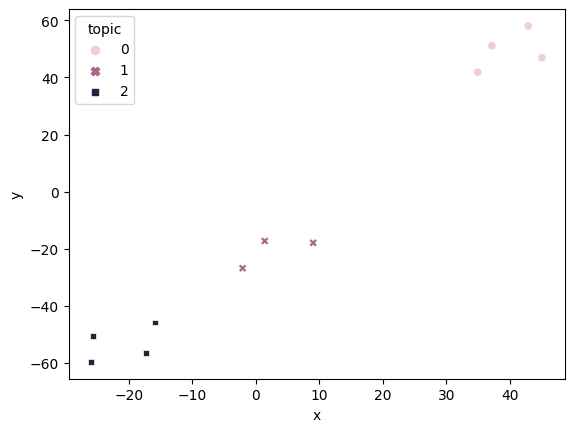

In [43]:
# Crear un gráfico de dispersión utilizando seaborn
sns.scatterplot(data=embedding, x="x", y="y", hue="topic", style="topic")

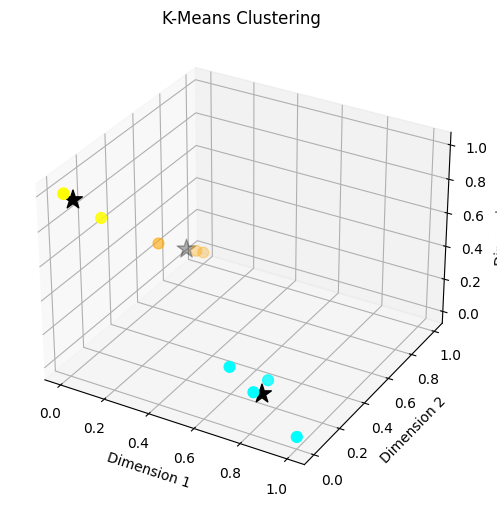

Centroides de los clusters:
 [[0.8113841  0.07060823 0.11720514]
 [0.0149321  0.03911644 0.94575921]
 [0.02417812 0.82727089 0.14577234]]
Grupos: [2 1 0 0 2 1 0 1 1 0 2]
Precisión: -0.4513630316609907
Cantidad de puntos por color:
- cyan: 4
- orange: 3
- yellow: 4


In [165]:
# define dataset
X = all_topics_numpy
# define the model
model = KMeans(n_clusters=3).fit(X)
centroids = model.cluster_centers_
labels = model.labels_
score = model.score(X)

# assign a cluster to each example
predicts = model.predict(X)
# create scatter plot for samples
colores = [ 'cyan', 'yellow', 'orange', 'black', 'pink', 'brown', 'purple']
asignar = [colores[row] for row in predicts]

# Count the number of points in each color
color_counts = np.unique(asignar, return_counts=True)

# Gráfica
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=asignar, s=60)
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c='k', marker='*', s=200)
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.set_title('K-Means Clustering')
plt.show()

print('Centroides de los clusters:\n', centroids)
print('Grupos:', labels)
print('Precisión:', score)
print('Cantidad de puntos por color:')
for color, count in zip(color_counts[0], color_counts[1]):
    print(f'- {color}: {count}')

# Discusión Parte 3

¿Creen ustedes que la mejor agrupación agrupacion si reune documentos similares? Justifiquen.


En realidad, todas las técnicas utilizadas entregan agrupaciones llamativamente adecuadas que, en términos generales, se consideran correctas, a menos que se esté obviando algo. Sin embargo, esto tiene mucho sentido. Todos los PDF tienen temáticas muy distintas, pero a su vez, estos PDF tienen internamente un corpus extenso, lo que hace que el corpus general sea muy robusto individualmente. Es difícil creer que existan subgrupos que se relacionen entre los temas de EEG, motores y PLN. Y si los hay, si se ve la gráfica de LDA, el pico más alto se logra en cuatro temas. Pero siendo directamente justos, los identificadores de temática se inclinan por el tema más latente, prevalente o, por así decirlo, más fuerte en cada PDF. Además, no son textos con palabras que tengan sentido figurado, doble sentido o que sean ambiguas. Aunque son de contextos completamente distintos, no existen tantas palabras entre ellos que puedan cambiar el significado de un tema  a otro. Estos textos son directos, lo cual brinda características completas que le permiten y facilitan al clasificador realizar las agrupaciones.

# Resultados

Las dos gráficas que presentan los resultados muestran lo esperado: tres grupos, dos de cuatro PDF y uno de tres. Esto se debe al corpus disponible, lo cual produce un resultado correcto pero no necesariamente satisfactorio. Sin embargo, pueden ocurrir dos situaciones:

El corpus era completo y coherente entre sus textos, lo que facilita que el modelo los agrupe adecuadamente.

El corpus era insuficiente y muy simple, lo que puede sesgar los resultados. Es importante tener en cuenta que una temática con PDF más largos que otros podría haber sesgado el agrupamiento, a pesar de que se haya realizado una normalización. Esto podría afectar negativamente la evaluación de los modelos.

En resumen, los resultados obtenidos pueden ser correctos, pero es importante considerar la calidad y representatividad del corpus utilizado para evitar sesgos y obtener resultados más satisfactorios.


La "Intertopic Distance Map" es una representación visual que utiliza la técnica de "Multidimensional Scaling" (MDS) para mostrar la proximidad espacial entre los PDF. Esta representación visual nos permite observar qué tan distantes están los PDF entre sí. Aunque hay muchas palabras en común, su relevancia no es tan destacada si se revisan las palabras que representan completamente la temática. Además, la coocurrencia no es tan alarmante, lo que facilita la diferenciación del corpus y permite que se agrupen correctamente.